## Notebook description: *Coconatfly_aPhN_Cosine.ipynb*

This notebook performs **cosine-similarity clustering analyses of aPhN (accessory pharyngeal nerve) sensory axons** using the **FlyWire connectome** via the `coconatfly` R package (workflow adapted from *McKim et al. 2024*).

New coconatfly users should start with the coconatfly tutorial https://github.com/natverse/coconatfly/

It contains three closely related analyses, each run in its own section with its own input/output paths:
- **aPhN** (all aPhN sensory axons)
- **aPhN1** (a subset of aPhN)
- **aPhN2** (a subset of aPhN)

### What it does (high-level; repeated per section)
1. **Loads a curated neuron list / annotations** from section-specific CSV files in `PATH_input`.
2. **Defines the target population** as a manually specified set of FlyWire **root IDs** (`ids_string`) and retrieves **FlyWire metadata** with `cf_meta(cf_ids(..., datasets="flywire"))`.
3. **Computes output connectivity partners** (postsynaptic targets) for each neuron using `cf_partners(..., partners="outputs")`, applying a **synapse threshold** (typically ≥5) to focus on stronger connections.
4. **Aggregates total output synapse counts** per neuron and optionally filters neurons by minimum total outputs (e.g., `output_count >= 5`).
5. Builds an output-connectivity representation and computes **pairwise cosine similarity** of output profiles.
6. Uses **hierarchical clustering** (commonly **Ward.D2**) to group neurons by similarity of downstream connectivity, then visualizes results as a **cosine heatmap / dendrogram** (interactive or static), saving figures to disk and also plotting inline.

### Key inputs (by section)
- **aPhN:** `aPhN_v1.0*.csv` (curated/annotated list; first column becomes `id`)
- **aPhN1:** `aPhN1_v1.0*.csv`
- **aPhN2:** `aPhN2_v1.0*.csv`
- A manually provided list of FlyWire **root IDs** (`ids_string`) used to query metadata/connectivity (some sections include an option “with putative DCSO” vs “without putative DCSO”).

### Key intermediate objects (as named in this notebook)
**aPhN section**
- `aPhN`: curated annotation table loaded from CSV (first column renamed to `id`)
- `apharyngeal`: FlyWire metadata table for selected neurons (joined with `aPhN` annotations)
- `apharyngeal_partners`: partner table from `cf_partners(..., partners="outputs")`
- `apharyngeal$key`: connectivity-derived key used by `cf_cosine_plot(...)` for cosine similarity and clustering

**aPhN1 section**
- `aPhN1`, `apharyngeal1`, partner table(s), and `apharyngeal1$key`

**aPhN2 section**
- `aPhN2`, `apharyngeal2`, partner table(s), and `apharyngeal2$key`

Additional derived objects used for visualization/annotation may include:
- `output_counts` (per-neuron summed output synapses)
- `hc` (an `hclust` object returned by `cf_cosine_plot(..., heatmap = FALSE)`)
- `*_meta` objects derived from `cf_meta(hc)` and `coconat::add_cluster_info(...)` for dendrogram labeling and cluster assignment

### Key outputs
- Cosine-similarity clustering figures (heatmap/dendrogram views), saved to **PDF** and/or **SVG** depending on the section/cell.
- Inline plots for quick inspection.
- Optional dendrogram-only exports (from `hc`) and colored dendrogram variants (when using `dendextend` / `dendroextras`).

### Notes / assumptions
- Connectivity is analyzed primarily on **output synapses** (presynaptic neuron → downstream targets) via `partners="outputs"`.
- Thresholds (partner synapse threshold, cosine threshold, and optional filtering by total output synapses) influence which neurons/partners contribute to similarity and clustering.
- In FlyWire FAFB v783 nomenclature: **aPhN** refers to the accessory/aPharyngeal nerve (often associated with sensory axons from structures such as VCSO/LSO); **PhN** refers to the pharyngeal nerve. Some sections optionally include/exclude **putative DCSO**-related IDs as part of the selected population.


###############################################################################################################################################


In [1]:

#----Figure_1-------------------------------------------------------------------
#-------------------------------------------------------------------------------
# This is the code for aPhN clustering analysis, adapted from McKim et al. 2024
#-------------------------------------------------------------------------------

#-load packages-----------------------------------------------------------------
library(tidyverse)
library(coconatfly)

###general variables:-----------------------------------------------------------
set.seed(42)
options(scipen=999)

PATH_input = "./Giakoumas-et-al/input/input_coconatfly/"
PATH_output = "./Giakoumas-et-al/output/figures/fig_S2/"
version <- "1.0"  # Specify version manually

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: nat

Loading required package: rgl

Registered S3 method overwritten by 'nat':
  method             from
  as.mesh3d.ashape3d rgl 

Some nat functions depend on a CMTK installation. See ?cmtk and README.md for details.


Attaching package: ‘nat’


The following object is masked from ‘package:rgl’:

    wire3d


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘packag

In [2]:
input_files = list.files(path = PATH_input, full.names = FALSE, recursive = FALSE)

In [3]:
input_files_tmp = list.files(path = paste0(PATH_input,"tmp/"),
full.names = FALSE, recursive = FALSE)
input_files = c(input_files,input_files_tmp)
v = read_delim(paste0(PATH_input,"aPhN_v1.0.csv"),
col_types  =  cols(version  =  col_character()),delim  =  ";")



Warning message:
“The following named parsers don't match the column names: version”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


In [4]:
v = v$version[1]

# set variables:----------------------------------------------------------------
aPhN = read_delim(paste0(PATH_input,"aPhN_v1.0",v,".csv"),
col_types = cols(root_id = col_character()),delim = ",")

Warning message:
“Unknown or uninitialised column: `version`.”


In [5]:
#-------------------------------------------------------------------------------
# clustering of all aPhN cells
colnames(aPhN)[1] <- 'id'
# paste0(aPhNid, collapse = ",")

#obtain meta data for all apharyngeal cells

In [6]:
#With putataive DCSO
ids_string <- paste(c(
    "720575940628131778", "720575940622199593", "720575940610259406", "720575940617828766",
    "720575940610981362", "720575940624266061", "720575940616308921", "720575940621916952",
    "720575940637130985", "720575940627454569", "720575940629009468", "720575940633165980",
    "720575940637165028", "720575940626014218", "720575940617121819", "720575940624948867",
    "720575940618788944", "720575940621689880", "720575940616616861", "720575940626217226",
    "720575940614830239", "720575940622346180", "720575940625032548", "720575940631069255",
    "720575940633791935", "720575940625163790", "720575940626983952", "720575940658442625",
    "720575940609913042", "720575940623834300", "720575940626015242", "720575940629358807",
    "720575940628891774", "720575940640601563", "720575940619928929", "720575940625031610",
    "720575940620885342", "720575940629972215", "720575940633660314", "720575940609787256",
    "720575940611643033", "720575940635739504", "720575940630734393", "720575940615015976",
    "720575940612420118", "720575940625972261", "720575940622606106", "720575940637019994",
    "720575940626520402", "720575940611168921", "720575940635005303", "720575940617668662",
    "720575940627219272", "720575940632596449", "720575940612642730", "720575940616934289",
    "720575940636943849", "720575940611630194", "720575940620575579", "720575940640611803",
    "720575940622406694", "720575940638054197", "720575940634826135", "720575940611351193",
    "720575940616791067", "720575940612819763", "720575940630597177", "720575940624186602",
    "720575940640554045", "720575940655071905", "720575940621848781", "720575940615879995",
    "720575940623511795", "720575940616196539", "720575940629112887", "720575940623458633",
    "720575940634667234", "720575940625173006", "720575940636542565", "720575940628344074",
    "720575940611056482", "720575940620699162", "720575940618889931", "720575940618156315",
    "720575940610103906"
), collapse = " ")


In [7]:
#Without Putative DCSO
ids_string <- paste(c(
    "720575940628131778", "720575940622199593", "720575940610259406", "720575940617828766",
    "720575940610981362", "720575940624266061", "720575940616308921", "720575940621916952",
    "720575940637130985", "720575940627454569", "720575940629009468", "720575940633165980",
    "720575940637165028", "720575940626014218", "720575940617121819", "720575940624948867",
    "720575940618788944", "720575940621689880", "720575940616616861", "720575940626217226",
    "720575940614830239", "720575940622346180", "720575940625032548", "720575940631069255",
    "720575940633791935", "720575940625163790", "720575940626983952", "720575940658442625",
    "720575940609913042", "720575940623834300", "720575940626015242", "720575940629358807",
    "720575940628891774", "720575940640601563", "720575940619928929", "720575940625031610",
    "720575940620885342", "720575940629972215", "720575940633660314", "720575940609787256",
    "720575940611643033", "720575940635739504", "720575940630734393", "720575940615015976",
    "720575940612420118", "720575940625972261", "720575940622606106", "720575940637019994",
    "720575940626520402", "720575940611168921", "720575940635005303", "720575940617668662",
    "720575940627219272", "720575940632596449", "720575940612642730", "720575940616934289",
    "720575940636943849", "720575940611630194", "720575940620575579", "720575940640611803",
    "720575940622406694", "720575940638054197", "720575940634826135", "720575940611351193",
    "720575940616791067", "720575940612819763", "720575940630597177", "720575940624186602",
    "720575940640554045", "720575940655071905", "720575940621848781", "720575940615879995",
    "720575940623511795", "720575940616196539", "720575940629112887", "720575940623458633",
    "720575940634667234", "720575940625173006", "720575940636542565", "720575940628344074",
    "720575940611056482", "720575940620699162", "720575940618889931", "720575940618156315",
    "720575940610103906"
), collapse = " ")


In [9]:
# Now, retrieve metadata for all root IDs using the concatenated string
apharyngeal <- cf_meta(cf_ids(ids_string, datasets = "flywire"))

Loading required namespace: git2r



In [10]:
apharyngeal = left_join(apharyngeal,aPhN,by = "id")
apharyngeal$side_name_id = paste(
apharyngeal$side,
apharyngeal$name,apharyngeal$id,sep="")

In [11]:
library(bit64)

apharyngeal_partners <- apharyngeal %>%
cf_partners(
threshold = 5,        # Minimum synapse count
partners = "outputs"  # Focus on output synapses
)

# 4. Aggregate synapse counts per neuron
output_counts <- apharyngeal_partners %>%
group_by(pre_id) %>%
summarise(output_count = sum(weight))

# 5. Convert pre_id to character for compatibility
output_counts <- output_counts %>%
mutate(pre_id = as.character(pre_id))

# 6. Join counts back to metadata
apharyngeal <- apharyngeal %>%
left_join(output_counts, by = c("id" = "pre_id")) %>%
filter(output_count >= 5)

Loading required package: bit


Attaching package: ‘bit’


The following object is masked from ‘package:dplyr’:

    symdiff


The following object is masked from ‘package:base’:

    xor


Attaching package bit64

package:bit64 (c) 2011-2017 Jens Oehlschlaegel

creators: integer64 runif64 seq :

coercion: as.integer64 as.vector as.logical as.integer as.double as.character as.bitstring

logical operator: ! & | xor != == < <= >= >

arithmetic operator: + - * / %/% %% ^

math: sign abs sqrt log log2 log10

math: floor ceiling trunc round

querying: is.integer64 is.vector [is.atomic} [length] format print str

values: is.na is.nan is.finite is.infinite

aggregation: any all min max range sum prod

cumulation: diff cummin cummax cumsum cumprod

access: length<- [ [<- [[ [[<-

combine: c rep cbind rbind as.data.frame

WARNING don't use as subscripts

WARNING semantics differ from integer

for more help type ?bit64


Attaching package: ‘bit64’


The following object is masked from ‘package:u

In [12]:
# after your left_join(aPhN) step you should have a column called `subsubclass`
# create a new label that combines subsubclass and id
apharyngeal <- apharyngeal %>%
  mutate(label_subsub = paste0(subsubclass, ":", id))

# then in your plot call, use that vector as labRow:
pdf(paste0(PATH_output, "Figure_1_WD2o", v, ".pdf"),
    width = 20, height = 16)
par(mar = c(10, 10, 4, 2) + 0.1)

apharyngeal %>%
  with(cf_cosine_plot(
    key,
    threshold      = 1,
    labRow         = label_subsub,   # ← here!
    interactive    = FALSE,
    partners       = "outputs",
    method         = "ward.D2",
    cexRow         = 0.3,            # might need to shrink further
    cexCol         = 0.3
  ))

dev.off()


Warning message in coconat::partner_summary2adjacency_matrix(x[["outputs"]], inputcol = "pre_key", :
“Dropping: 518/7668 neurons representing 2742/65425 synapses due to missing ids!”


pdf 
  2

In [13]:
# Generate the plot with corrected labels (use 'id' instead of 'side_name_id')
pdf(paste0("./Giakoumas-et-al/output/figures/fig_S2/aPhN_Figure_WD2o", v, ".pdf"),
width = 20, height = 16)
par(mar = c(10, 10, 4, 2) + 0.1)
apharyngeal %>%
with(cf_cosine_plot(
key,
threshold = 1,
labRow = id,  # Use raw root IDs for labels
interactive = FALSE,
partners = "outputs",
method = "ward.D2",
cexRow = 0.3,  # Reduce font size for row labels
cexCol = 0.3   # Reduce font size for column labels
))
dev.off()

Warning message in coconat::partner_summary2adjacency_matrix(x[["outputs"]], inputcol = "pre_key", :
“Dropping: 518/7668 neurons representing 2742/65425 synapses due to missing ids!”


pdf 
  2

Warning message in coconat::partner_summary2adjacency_matrix(x[["outputs"]], inputcol = "pre_key", :
“Dropping: 518/7668 neurons representing 2742/65425 synapses due to missing ids!”


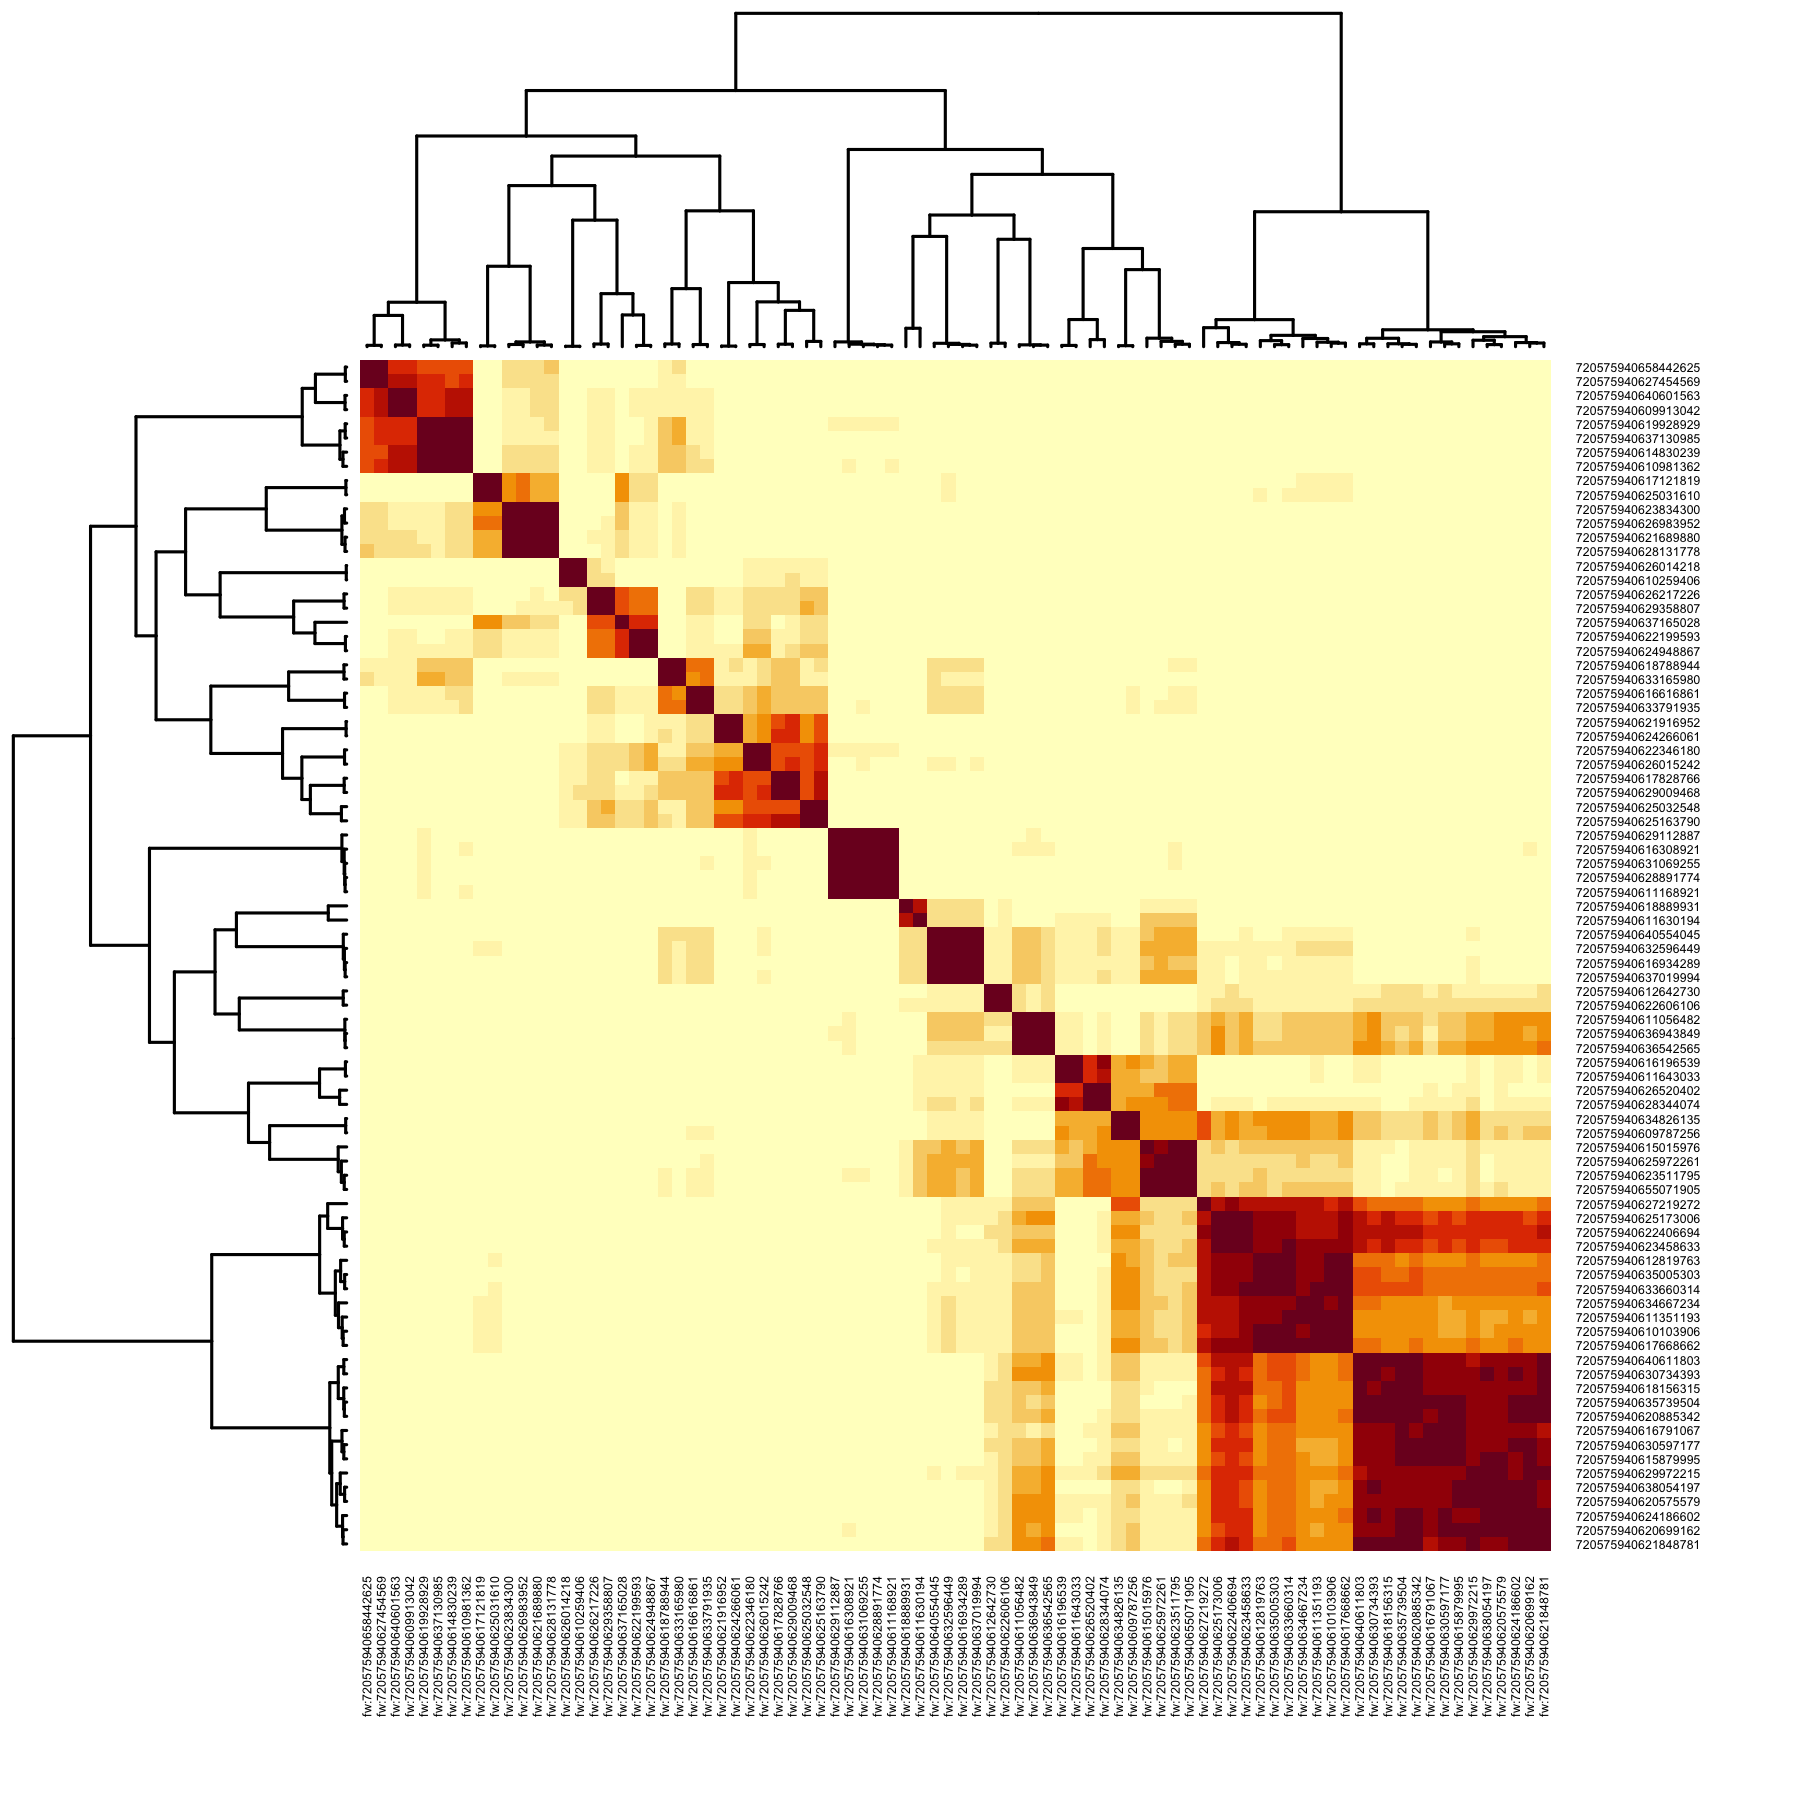

In [15]:
options(
  repr.plot.width  = 6,    # inches
  repr.plot.height = 6,    # inches
  repr.plot.res    = 300   # DPI (pixels per inch)
)


# Generate the plot with corrected labels (use 'id' instead of 'side_name_id')
par(mar = c(10, 10, 4, 2) + 0.1)
apharyngeal %>%
with(cf_cosine_plot(
        key,
        threshold = 1,
        labRow = id,  # Use raw root IDs for labels
        interactive = FALSE,
        partners = "outputs",
        method = "ward.D2",
        cexRow = 0.3,  # Reduce font size for row labels
        cexCol = 0.3   # Reduce font size for column labels
))


###############################################################################################################################################


In [16]:
#----Figure_1-------------------------------------------------------------------
#-------------------------------------------------------------------------------
# This is the code for aPhN1 clustering analysis, adapted from McKim et al. 2024
#-------------------------------------------------------------------------------

#-load packages-----------------------------------------------------------------
library(tidyverse)
library(coconatfly)

###general variables:-----------------------------------------------------------
set.seed(42)
options(scipen=999)

PATH_input = "./Giakoumas-et-al/input/input_coconatfly/"
PATH_output = "./Giakoumas-et-al/output/figures/fig_S2/"
version <- "1.0"  # Specify version manually

In [17]:
input_files = list.files(path = PATH_input, full.names = FALSE, recursive = FALSE)




In [18]:
input_files_tmp = list.files(path = paste0(PATH_input,"tmp/"),
full.names = FALSE, recursive = FALSE)
input_files = c(input_files,input_files_tmp)
v = read_delim(paste0(PATH_input,"aPhN1_v1.0.csv"),
col_types  =  cols(version  =  col_character()),delim  =  ";")



Warning message:
“The following named parsers don't match the column names: version”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


In [19]:
v = v$version[1]

# set variables:----------------------------------------------------------------
aPhN1 = read_delim(paste0(PATH_input,"aPhN1_v1.0",v,".csv"),
col_types = cols(root_id = col_character()),delim = ",")

Warning message:
“Unknown or uninitialised column: `version`.”


In [20]:
#-------------------------------------------------------------------------------
# clustering of all aPhN1 cells
colnames(aPhN1)[1] <- 'id'
# paste0(aPhNid, collapse = ",")

#obtain meta data for all apharyngeal cells

In [21]:
#With putative DCSO
ids_string <- paste(c(
    "720575940627454569", "720575940658442625", "720575940640601563", "720575940609913042",
    "720575940619928929", "720575940637130985", "720575940614830239", "720575940610981362",
    "720575940617121819", "720575940625031610", "720575940621689880", "720575940628131778",
    "720575940623834300", "720575940626983952", "720575940622199593", "720575940624948867",
    "720575940626217226", "720575940629358807", "720575940637165028", "720575940631284511",
    "720575940628673474", "720575940638608803", "720575940616562150", "720575940626014218",
    "720575940610259406", "720575940621916952", "720575940624266061", "720575940622346180",
    "720575940626015242", "720575940617828766", "720575940629009468", "720575940625032548",
    "720575940625163790", "720575940628329546", "720575940635391845", "720575940632423394",
    "720575940621870349", "720575940618788944", "720575940633165980", "720575940616616861",
    "720575940633791935", "720575940638419534", "720575940623660558", "720575940630893196",
    "720575940611211417"

),
    collapse = " ")

In [22]:
#Without putative DCSO
ids_string <- paste(c(
    "720575940627454569", "720575940658442625", "720575940640601563", "720575940609913042",
    "720575940619928929", "720575940637130985", "720575940614830239", "720575940610981362",
    "720575940617121819", "720575940625031610", "720575940621689880", "720575940628131778",
    "720575940623834300", "720575940626983952", "720575940622199593", "720575940624948867",
    "720575940626217226", "720575940629358807", "720575940637165028", "720575940626014218",
    "720575940610259406", "720575940621916952", "720575940624266061", "720575940622346180",
    "720575940626015242", "720575940617828766", "720575940629009468", "720575940625032548",
    "720575940625163790", "720575940618788944", "720575940633165980", "720575940616616861",
    "720575940633791935"
),
    collapse = " ")


In [25]:
# Now, retrieve metadata for all root IDs using the concatenated string
apharyngeal1 <- cf_meta(cf_ids(ids_string, datasets = "flywire"))

In [26]:
apharyngeal1 = left_join(apharyngeal1,aPhN1,by = "id")
apharyngeal1$side_name_id = paste(
apharyngeal1$side,
apharyngeal1$name,apharyngeal1$id,sep="")

In [27]:
library(bit64)

apharyngeal_partners <- apharyngeal1 %>%
cf_partners(
threshold = 5,        # Minimum synapse count
partners = "outputs"  # Focus on output synapses
)

# 4. Aggregate synapse counts per neuron
output_counts <- apharyngeal_partners %>%
group_by(pre_id) %>%
summarise(output_count = sum(weight))

# 5. Convert pre_id to character for compatibility
output_counts <- output_counts %>%
mutate(pre_id = as.character(pre_id))

# 6. Join counts back to metadata
apharyngeal1 <- apharyngeal1 %>%
left_join(output_counts, by = c("id" = "pre_id")) %>%
filter(output_count >= 5)

In [43]:
# Generate the plot with corrected labels (use 'id' instead of 'side_name_id')
pdf(
paste0("./Giakoumas-et-al/output/figures/fig_S2/aPhN1_WD2o", v, ".pdf"),
width = 15,  # Increase width further
height = 10  # Increase height further
)
par(mar = c(15, 15, 4, 15) + .1)  # Adjust margins to make space for labels
apharyngeal1 %>%
with(cf_cosine_plot(
key,
threshold = 1,
labRow = id,  # Use raw root IDs for labels
interactive = FALSE,
partners = "outputs",
method = "ward.D2",
cexRow = 0.8,  # Reduce font size for row labels
cexCol = 0.4   # Reduce font size for column labels
))
dev.off()

Warning message in coconat::partner_summary2adjacency_matrix(x[["outputs"]], inputcol = "pre_key", :
“Dropping: 204/4384 neurons representing 703/38837 synapses due to missing ids!”


pdf 
  2

Warning message in coconat::partner_summary2adjacency_matrix(x[["outputs"]], inputcol = "pre_key", :
“Dropping: 204/4384 neurons representing 703/38837 synapses due to missing ids!”


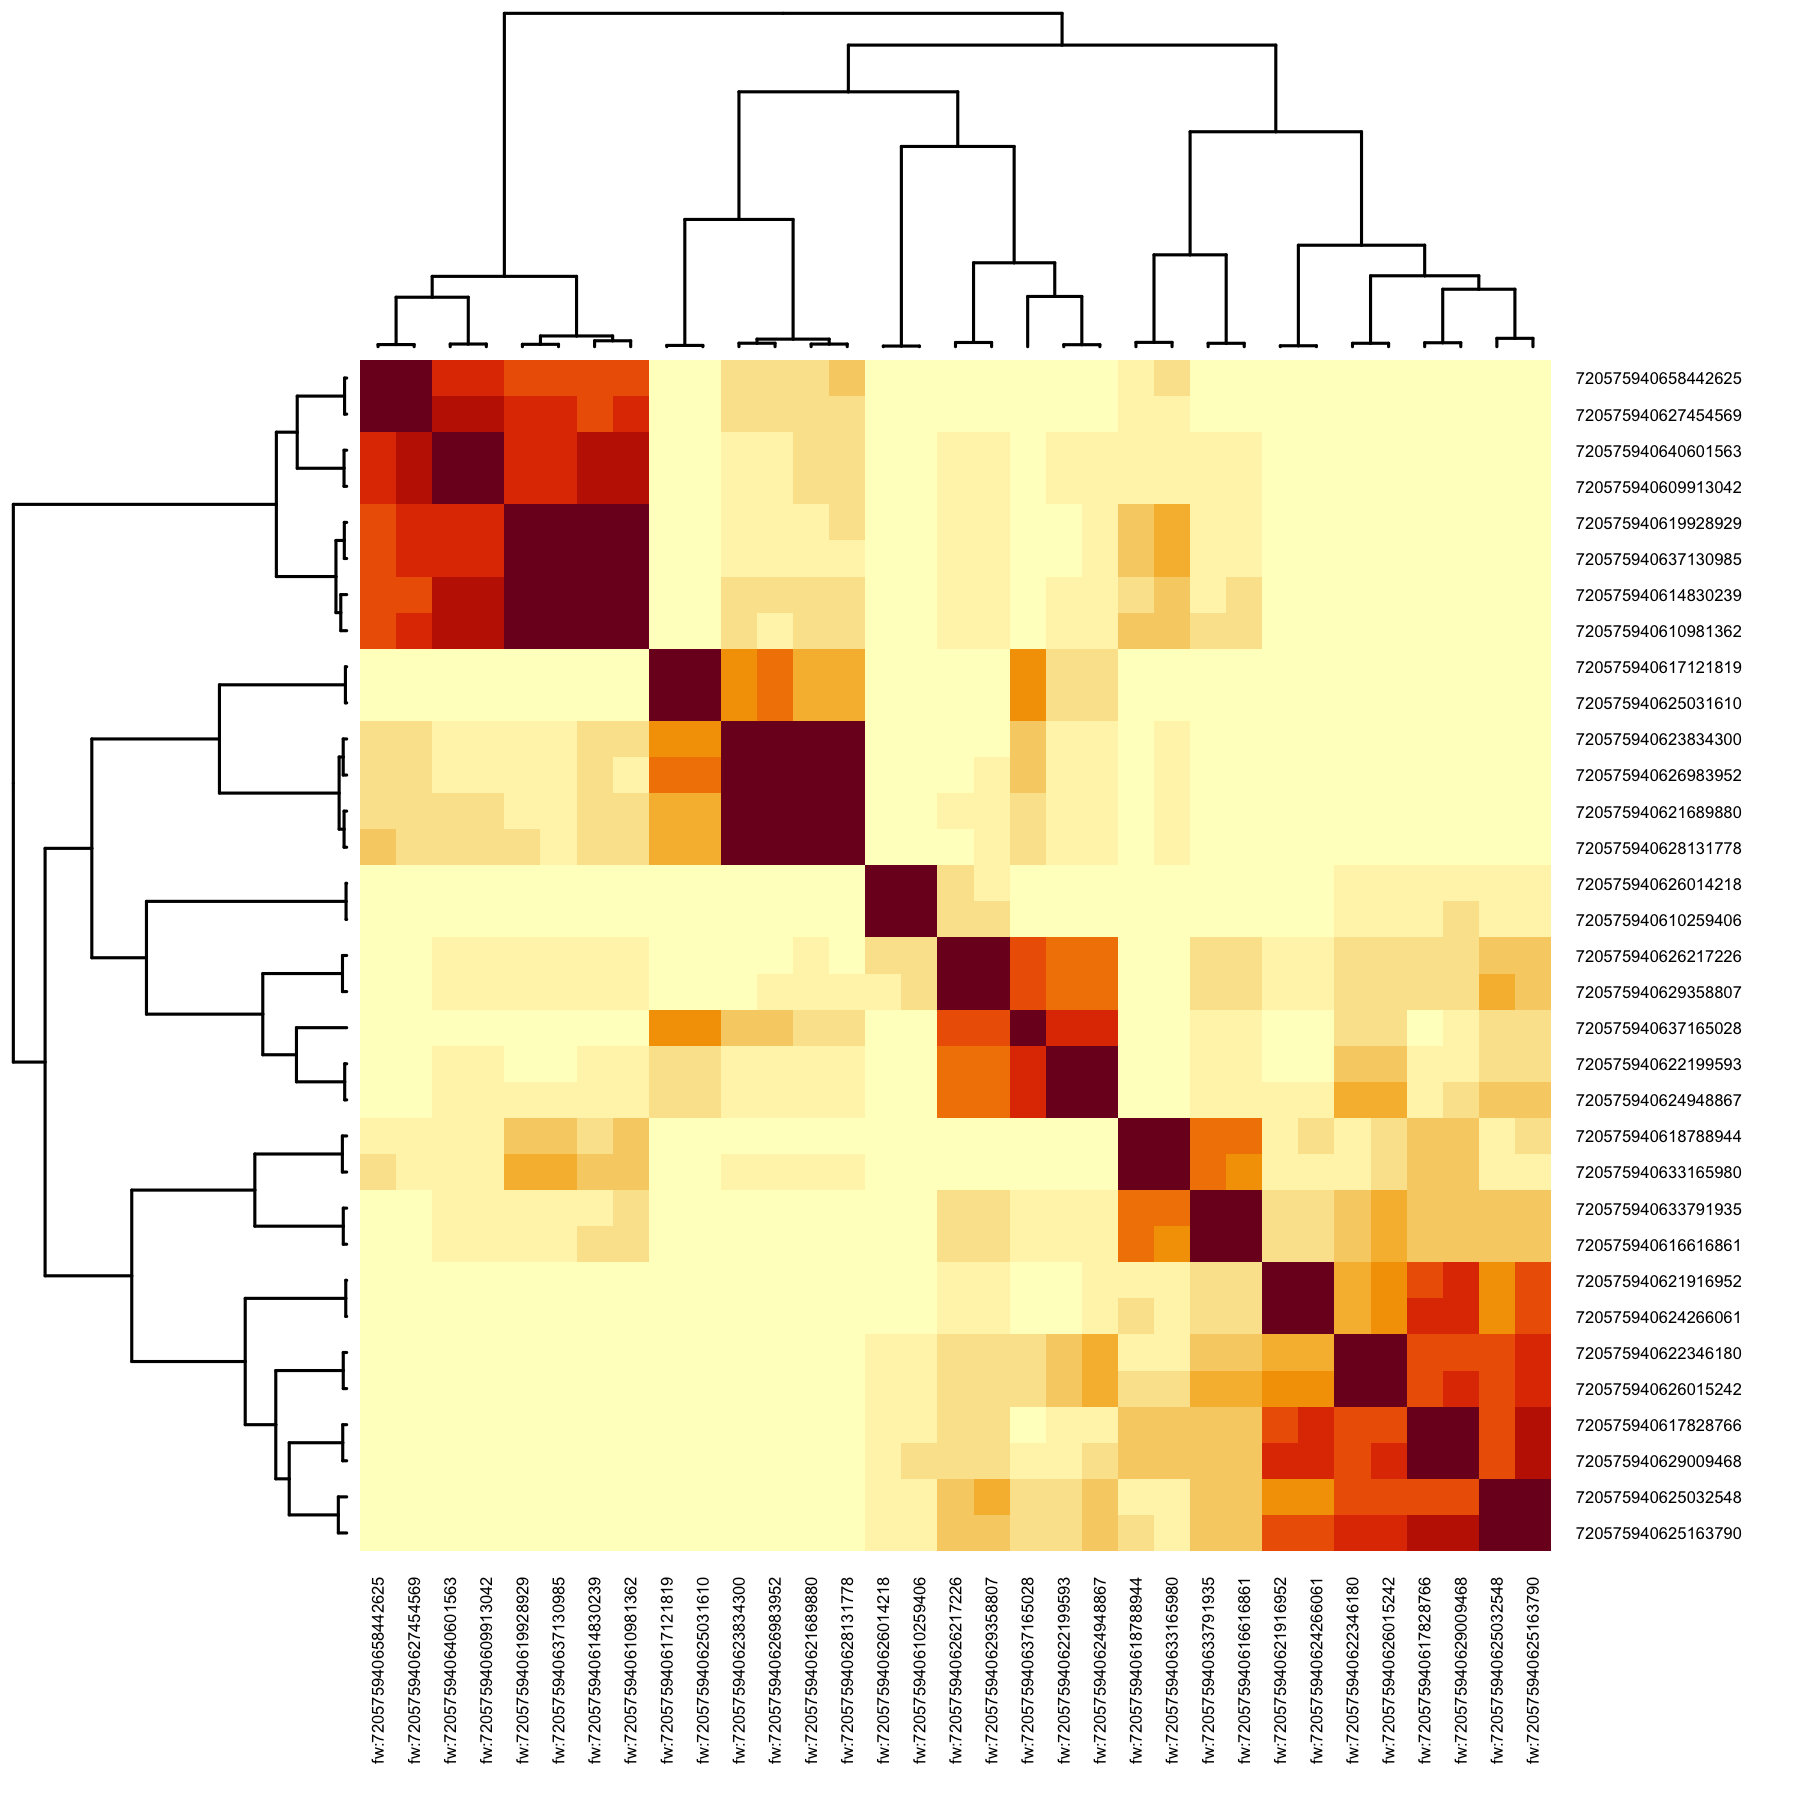

In [30]:

par(mar = c(15, 15, 4, 15) + .1)  # Adjust margins to make space for labels
apharyngeal1 %>%
with(cf_cosine_plot(
        key,
        threshold = 1,
        labRow = id,  # Use raw root IDs for labels
        interactive = FALSE,
        partners = "outputs",
        method = "ward.D2",
        cexRow = 0.4,  # Reduce font size for row labels
        cexCol = 0.4   # Reduce font size for column labels
))


###################################################################################################################################################################

In [1]:
#----Figure_1-------------------------------------------------------------------
#-------------------------------------------------------------------------------
# This is the code for aPhN2 clustering analysis, adapted from McKim et al. 2024
#-------------------------------------------------------------------------------

#-load packages-----------------------------------------------------------------
library(tidyverse)
library(coconatfly)

###general variables:-----------------------------------------------------------
set.seed(42)
options(scipen=999)

PATH_input = "./Giakoumas-et-al/input/input_coconatfly/"
PATH_output = "./Giakoumas-et-al/output/figures/fig_S2/"
version <- "1.0"  # Specify version manually

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: nat

Loading required package: rgl

Registered S3 method overwritten by 'nat':
  method             from
  as.mesh3d.ashape3d rgl 

Some nat functions depend on a CMTK installation. See ?cmtk and README.md for details.


Attaching package: ‘nat’


The following object is masked from ‘package:rgl’:

    wire3d


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘packag

In [2]:
input_files = list.files(path = PATH_input, full.names = FALSE, recursive = FALSE)




In [3]:
input_files_tmp = list.files(path = paste0(PATH_input,"tmp/"),
full.names = FALSE, recursive = FALSE)
input_files = c(input_files,input_files_tmp)
v = read_delim(paste0(PATH_input,"aPhN2_v1.0.csv"),
col_types  =  cols(version  =  col_character()),delim  =  ";")



Warning message:
“The following named parsers don't match the column names: version”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


In [4]:
v = v$version[1]

# set variables:----------------------------------------------------------------
aPhN2 = read_delim(paste0(PATH_input,"aPhN2_v1.0",v,".csv"),
col_types = cols(root_id = col_character()),delim = ",")

Warning message:
“Unknown or uninitialised column: `version`.”


In [5]:
#-------------------------------------------------------------------------------
# clustering of all aPhN2 cells
colnames(aPhN2)[1] <- 'id'
# paste0(aPhNid, collapse = ",")

#obtain meta data for all apharyngeal2 cells

In [6]:
ids_string <- paste(c(
"720575940627219272", "720575940625173006", "720575940622406694", "720575940623458633",
"720575940612819763", "720575940635005303", "720575940633660314", "720575940634667234",
"720575940611351193", "720575940610103906", "720575940617668662", "720575940640611803",
"720575940630734393", "720575940618156315", "720575940635739504", "720575940620885342",
"720575940616791067", "720575940630597177", "720575940615879995", "720575940629972215",
"720575940638054197", "720575940620575579", "720575940624186602", "720575940620699162",
"720575940621848781", "720575940629112887", "720575940616308921", "720575940631069255",
"720575940611168921", "720575940628891774", "720575940618889931", "720575940611630194",
"720575940640554045", "720575940632596449", "720575940616934289", "720575940637019994",
"720575940612642730", "720575940622606106", "720575940611056482", "720575940636943849",
"720575940636542565", "720575940616196539", "720575940611643033", "720575940626520402",
"720575940628344074", "720575940634826135", "720575940609787256", "720575940615015976",
"720575940625972261", "720575940623511795", "720575940655071905"
),
    collapse = " ")

In [9]:
# Now, retrieve metadata for all root IDs using the concatenated string
apharyngeal2 <- cf_meta(cf_ids(ids_string, datasets = "flywire"))

Loading required namespace: git2r



In [10]:
apharyngeal2 = left_join(apharyngeal2,aPhN2,by = "id")
apharyngeal2$side_name_id = paste(
apharyngeal2$side,
apharyngeal2$name,apharyngeal2$id,sep="")

In [11]:
library(bit64)

apharyngeal2_partners <- apharyngeal2 %>%
cf_partners(
threshold = 5,        # Minimum synapse count
partners = "outputs"  # Focus on output synapses
)

# 4. Aggregate synapse counts per neuron
output_counts <- apharyngeal2_partners %>%
group_by(pre_id) %>%
summarise(output_count = sum(weight))

# 5. Convert pre_id to character for compatibility
output_counts <- output_counts %>%
mutate(pre_id = as.character(pre_id))

# 6. Join counts back to metadata
apharyngeal2 <- apharyngeal2 %>%
left_join(output_counts, by = c("id" = "pre_id")) %>%
filter(output_count >= 5)

Loading required package: bit


Attaching package: ‘bit’


The following object is masked from ‘package:dplyr’:

    symdiff


The following object is masked from ‘package:base’:

    xor


Attaching package bit64

package:bit64 (c) 2011-2017 Jens Oehlschlaegel

creators: integer64 runif64 seq :

coercion: as.integer64 as.vector as.logical as.integer as.double as.character as.bitstring

logical operator: ! & | xor != == < <= >= >

arithmetic operator: + - * / %/% %% ^

math: sign abs sqrt log log2 log10

math: floor ceiling trunc round

querying: is.integer64 is.vector [is.atomic} [length] format print str

values: is.na is.nan is.finite is.infinite

aggregation: any all min max range sum prod

cumulation: diff cummin cummax cumsum cumprod

access: length<- [ [<- [[ [[<-

combine: c rep cbind rbind as.data.frame

WARNING don't use as subscripts

WARNING semantics differ from integer

for more help type ?bit64


Attaching package: ‘bit64’


The following object is masked from ‘package:u

In [16]:
# Generate the plot with corrected labels (use 'id' instead of 'side_name_id')
svg(
paste0("./Giakoumas-et-al/output/figures/fig_S2/aPhN2_WD2o", v, ".svg"),
width = 15,  # Increase width further
height = 10  # Increase height further
)
par(mar = c(15, 15, 4, 15) + .1)  # Adjust margins to make space for labels
apharyngeal2 %>%
with(cf_cosine_plot(
key,
threshold = 1,
labRow = id,  # Use raw root IDs for labels
interactive = FALSE,
partners = "outputs",
method = "ward.D2",
cexRow = 0.8,  # Reduce font size for row labels
cexCol = 0.4   # Reduce font size for column labels
))
dev.off()

Warning message in coconat::partner_summary2adjacency_matrix(x[["outputs"]], inputcol = "pre_key", :
“Dropping: 314/3284 neurons representing 2039/26588 synapses due to missing ids!”


pdf 
  2

Warning message in coconat::partner_summary2adjacency_matrix(x[["outputs"]], inputcol = "pre_key", :
“Dropping: 314/3284 neurons representing 2039/26588 synapses due to missing ids!”


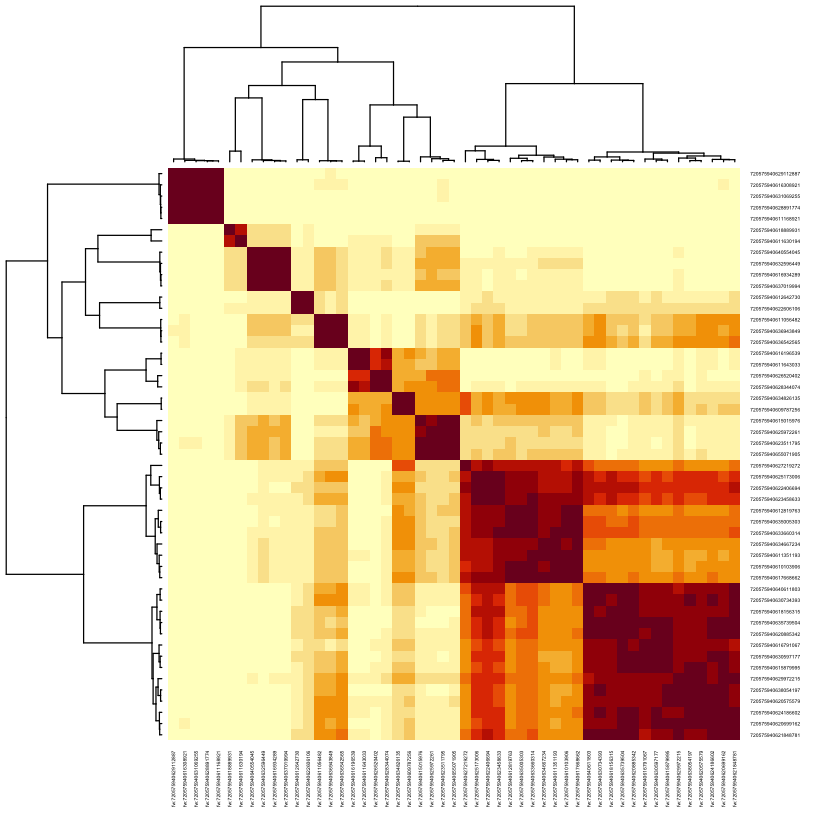

In [14]:
# Generate the plot with corrected labels (use 'id' instead of 'side_name_id')
par(mar = c(15, 15, 4, 15) + .1)  # Adjust margins to make space for labels
apharyngeal2 %>%
with(cf_cosine_plot(
        key,
        threshold = 1,
        labRow = id,  # Use raw root IDs for labels
        interactive = FALSE,
        partners = "outputs",
        method = "ward.D2",
        cexRow = 0.3,  # Reduce font size for row labels
        cexCol = 0.3   # Reduce font size for column labels
))
